In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score

import proplot as pplt

from roc_curve.bootstrap_samples import _bootstrap_samples
from roc_curve.plotting_proplot import ROC_Curve_proplot

results_dir = '/home/scratch/wpotosna/data'

In [2]:
test_results = pd.read_csv(results_dir+'/test_results.csv')
train_results = pd.read_csv(results_dir+'/train_results.csv')

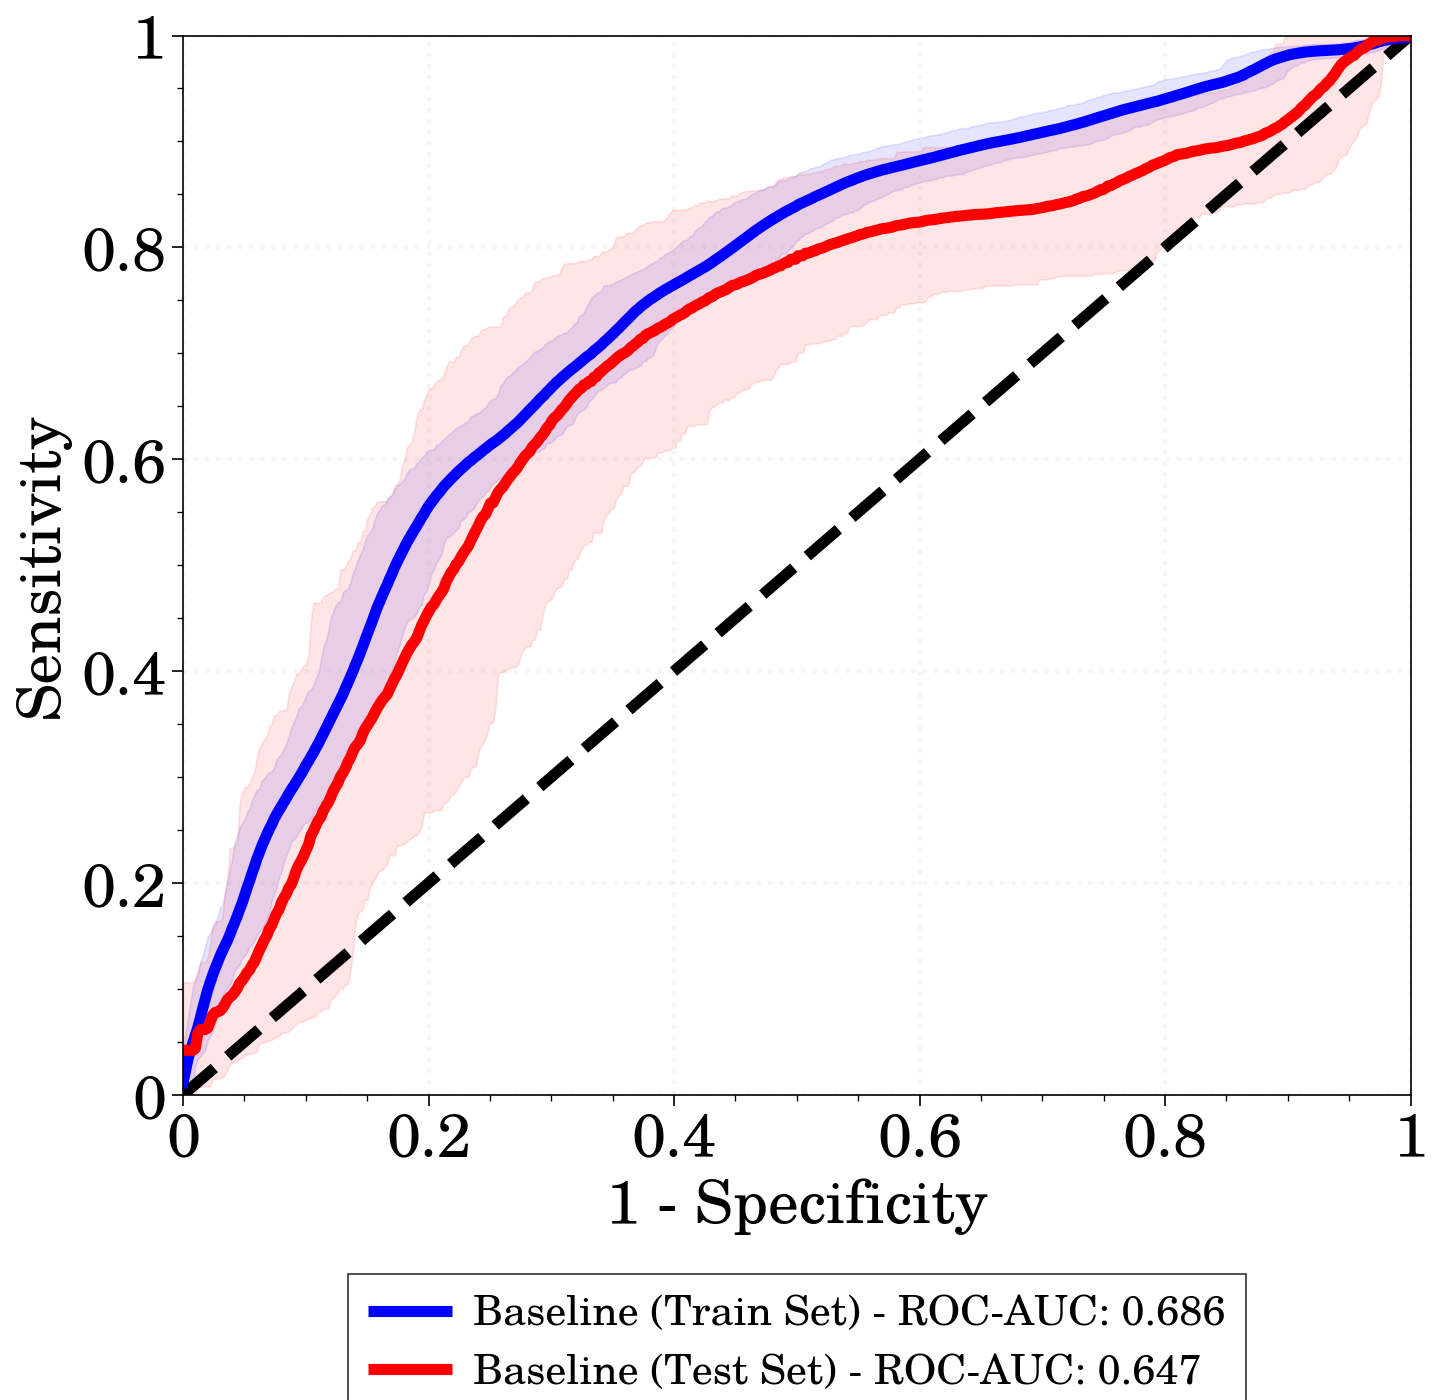

In [10]:


truth = [train_results.ClinVar_labels, test_results.ClinVar_labels]
preds = [train_results.EVE_scores, test_results.EVE_scores]
folds = [None, None]
labels = ['Baseline (Train Set) - ROC-AUC: {}'.format(round(roc_auc_score(train_results.ClinVar_labels, train_results.EVE_classes_100_pct_retained), 3)),
          'Baseline (Test Set) - ROC-AUC: {}'.format(round(roc_auc_score(test_results.ClinVar_labels, test_results.EVE_classes_100_pct_retained), 3))]
colors = ['blue', 'red']

plt = ROC_Curve_proplot(axis_label_size='22', axis_tick_size='22', legend_text_size='15')

plt.plot(true_labels=truth, predictions=preds, folds=folds, xrange=(0,1), yrange=(0,1), direction='TPRvsFPR', 
         x_scale='linear', line_width=4, line_dash='solid', line_color=colors, legend_label=labels, 
         legend_location='lower center', ci_method='bootstrap', alpha=0.05, bootstrap_iters=500, random_seed=0,
         save_dir='/home/scratch/wpotosna/roc_curve.png')

plt.plot(true_labels=truth, predictions=preds, folds=folds, xrange=(0,1), yrange=(0,1), direction='TPRvsFPR', 
         x_scale='log', line_width=4, line_dash='solid', line_color=colors, legend_label=labels, 
         legend_location='lower center', ci_method='bootstrap', alpha=0.05, bootstrap_iters=5, random_seed=0,
         #save_dir='/home/scratch/wpotosna/roc_curve.png'
        )

/zfsauton2/home/wpotosna/.conda/envs/pgm_env/lib/python3.10/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


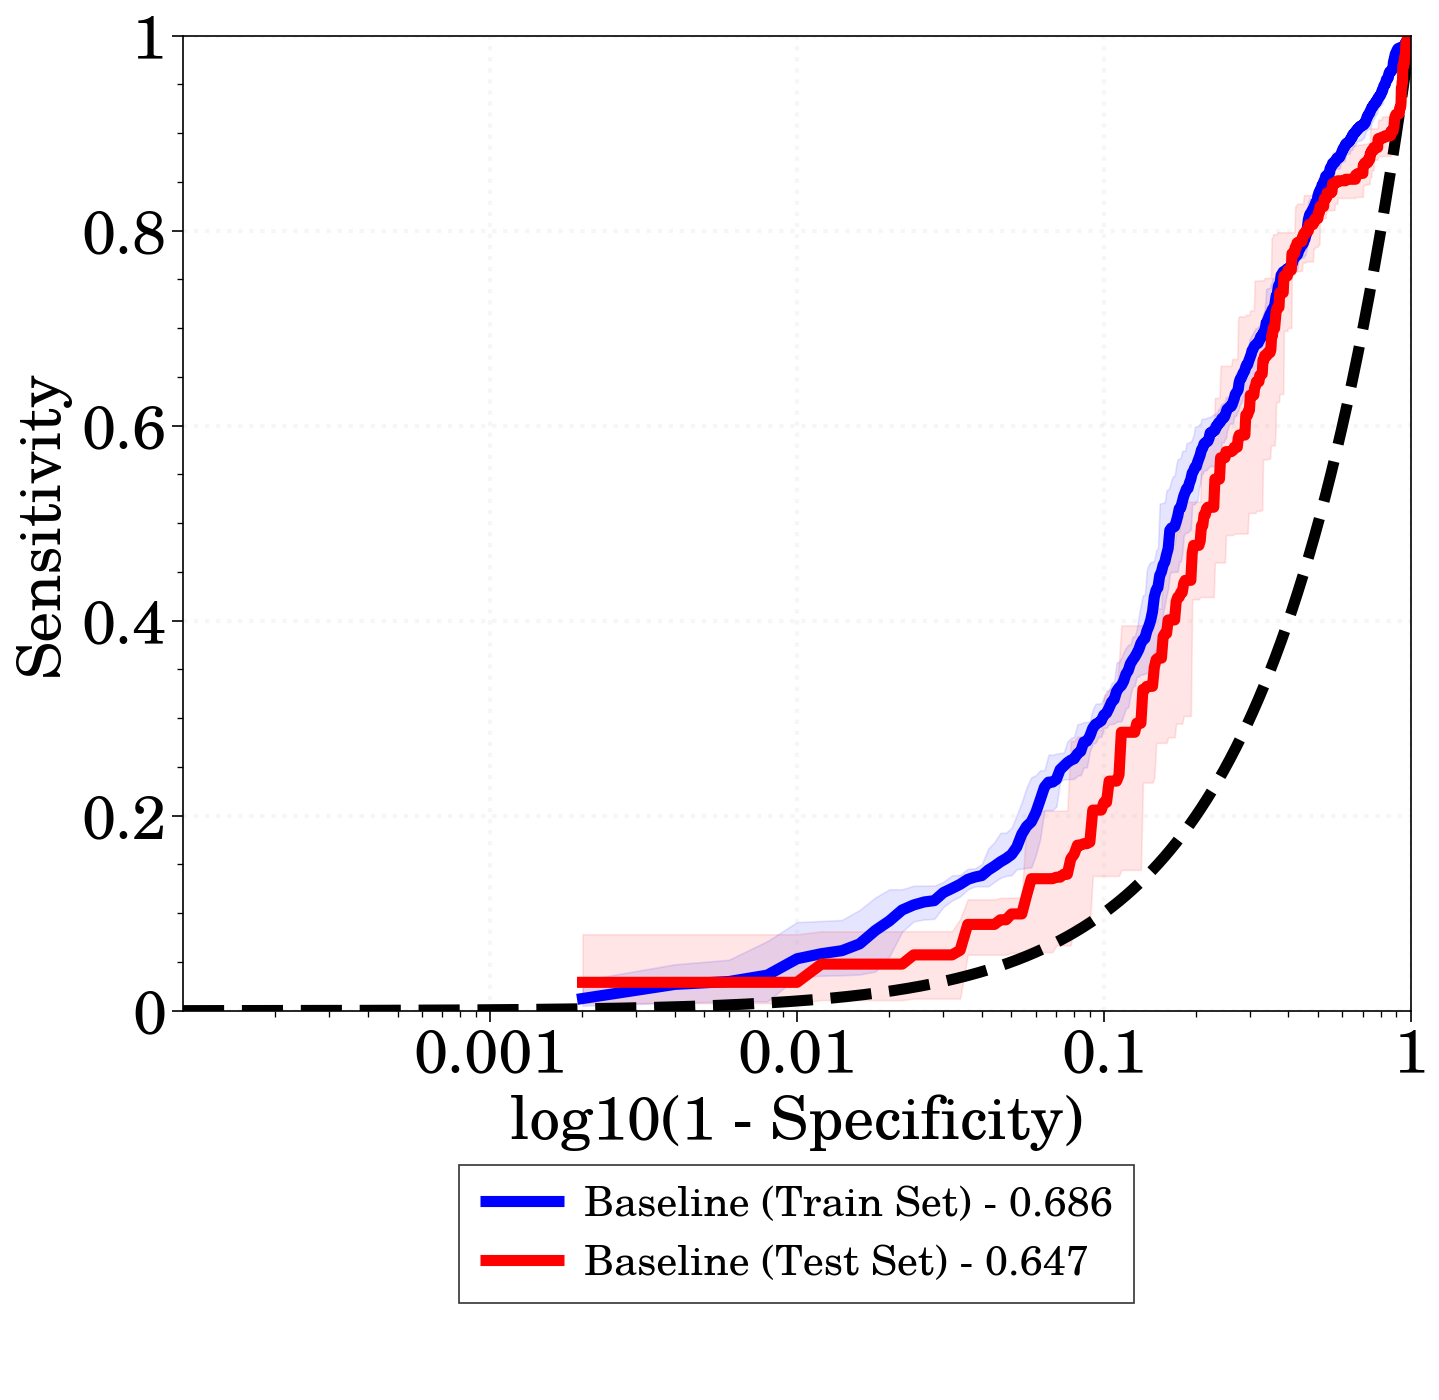

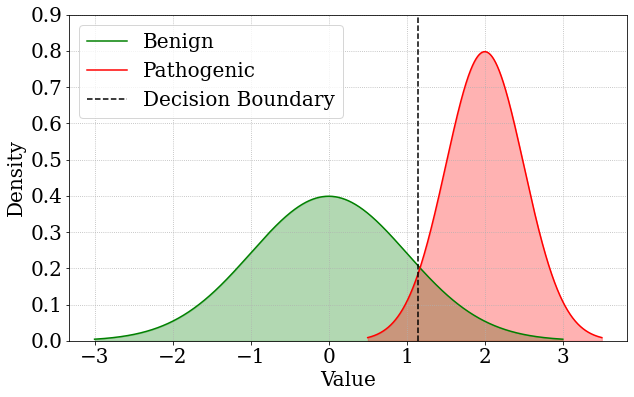

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the parameters for the two normal distributions
mu1 = 0
sigma1 = 1
mu2 = 2
sigma2 = 0.5


# Generate some random data from the two distributions
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 1000)
x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 1000)
y1 = 1/(sigma1*np.sqrt(2*np.pi))*np.exp(-(x1-mu1)**2/(2*sigma1**2))
y2 = 1/(sigma2*np.sqrt(2*np.pi))*np.exp(-(x2-mu2)**2/(2*sigma2**2))


fig=plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'serif'
# Plot the two normal distributions as smooth lines
plt.plot(x1, y1, label='Benign', color='green')
plt.plot(x2, y2, label='Pathogenic', color='red')
plt.fill_between(x1, y1, 0, alpha=0.3, color='green')
plt.fill_between(x2, y2, 0, alpha=0.3, color='red')

plt.plot(np.repeat(1.15, 5), np.linspace(0, 1, 5), '--', color='black', label='Decision Boundary')


# Add a legend and labels for the axes
plt.grid(True, ls=':')
plt.legend(fontsize=20)
plt.xlabel('Value', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.ylim([0, 0.9])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('./GMM.png')